In [6]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img

Using TensorFlow backend.


## Examine dataset
We examine some information regarding the cats and dogs images. We also note that the labels of the images contains the classification of the images and would need to be 'extracted'.

In [159]:
def label_image(filenames):

    categories = []
    for filename in filenames:
        category = filename.split('.')[0]
        if category == 'cat':
            categories.append('cat')
        else:
            categories.append('dog')

    df = pd.DataFrame({'filename': filenames, 'category': categories}, columns=['filename','category'])
    
    return df

In [160]:
PATH = "../Activity 9 ML6/dogs-vs-cats/train/"
filenames = os.listdir(PATH)

files = label_image(filenames)
files.sample(10)

,filename,category
19488,dog.5037.jpg,dog
6679,cat.476.jpg,cat
18168,dog.385.jpg,dog
19239,dog.4813.jpg,dog
19338,dog.4902.jpg,dog
17558,dog.330.jpg,dog
19919,dog.5425.jpg,dog
24156,dog.9239.jpg,dog
18826,dog.4441.jpg,dog
21968,dog.727.jpg,dog


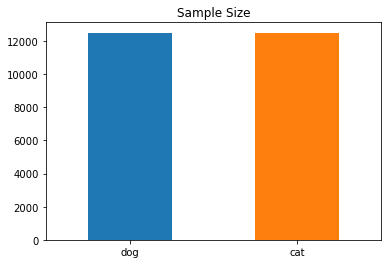

dog    12500
cat    12500
Name: category, dtype: int64


In [164]:
#image count
files['category'].value_counts().plot.bar(rot=0)
plt.title("Sample Size")
plt.savefig("sample_size.png",bbox_inches='tight',dpi=300)
plt.show()

print(files['category'].value_counts())

The number of cats and dogs images have a total of 25,000 with 12,500 for each cat and dog image. Since sample size is equal, it will not introduce size biases for classification.

(320, 239)


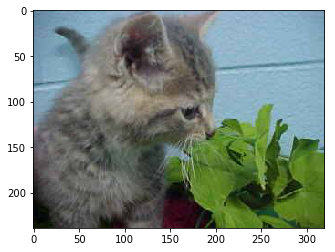

In [65]:
#random image
sample = random.choice(filenames)
image = load_img(PATH+sample)
print(image.size)
plt.imshow(image)

## Label image data and convert to array
We extract equal samples of cats and dogs and apply their corresponding labels (1=="cat",0=="dog"). Since the most common image shape is 375x500, we resize the image to this size or proportional to this size (e.g. (94,125)).

In [55]:
def data_image(PATH, FILE_LIST, IMG_SIZE, LABEL):
    
    categories = []
    images = []
    
    for filename in FILE_LIST:
        
        #create label 1==cat, 0==dog
        categories.append(LABEL)
            
        #convert image to array
        img = Image.open(PATH+filename)
        img = img.resize(IMG_SIZE)
        np_img = np.array(img)
        images.append(np_img)
        
    return images, categories

### Create training set

In [66]:
TRAIN_SAMPLE, IMG_SIZE = 2500, (125,167)
CAT_TRAIN = filenames[:TRAIN_SAMPLE]
DOG_TRAIN = filenames[-TRAIN_SAMPLE:]

X_train_cat, y_train_cat = data_image(PATH,CAT_TRAIN,IMG_SIZE,1)
X_train_dog, y_train_dog = data_image(PATH,DOG_TRAIN,IMG_SIZE,0)

In [67]:
x_train_set = np.concatenate([X_train_cat,X_train_dog])
y_train_set = np.concatenate([y_train_cat,y_train_dog])

print("x-train shape:",x_train_set.shape)
print("y-train shape:",y_train_set.shape)

x-train shape: (5000, 167, 125, 3)
y-train shape: (5000,)


### Create validation set
We choose a validation size that is 10% of the training set

In [69]:
VALID_SAMPLE = 500
CAT_VALID = filenames[(TRAIN_SAMPLE+1):(TRAIN_SAMPLE+VALID_SAMPLE+1)]
DOG_VALID = filenames[12500:12500+VALID_SAMPLE]

X_valid_cat, y_valid_cat = data_image(PATH,CAT_VALID,IMG_SIZE,1)
X_valid_dog, y_valid_dog = data_image(PATH,DOG_VALID,IMG_SIZE,0)

In [70]:
x_valid_set = np.concatenate([X_valid_cat,X_valid_dog])
y_valid_set = np.concatenate([y_valid_cat,y_valid_dog])

print("x-train shape:",x_valid_set.shape)
print("y-train shape:",y_valid_set.shape)

x-train shape: (1000, 167, 125, 3)
y-train shape: (1000,)


## Fully connected MLP
Train images using MLP for comparison

In [60]:
total_pixels = IMG_SIZE[0] * IMG_SIZE[1] * 3
fc_size = 512

inputs = keras.Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3), name='ani_image')
x = layers.Flatten(name = 'flattened_img')(inputs) #turn image to vector.

x = layers.Dense(fc_size, activation='relu', name='first_layer')(x)
outputs = layers.Dense(1, activation='sigmoid', name='class')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [61]:
customAdam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="mean_squared_error",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])
              
print('# Fit model on training data')

history = model.fit(x_train_set, 
                    y_train_set, 
                    batch_size=30, 
                    shuffle = True, #important since we loaded cats first, dogs second.
                    epochs=2,
                    validation_data=(x_valid_set, y_valid_set))

# Fit model on training data
Train on 4000 samples, validate on 1000 samples
Epoch 1/2
4000/4000 [==============================] - 108s 27ms/step - loss: 0.5000 - binary_crossentropy: 8.0553 - mean_squared_error: 0.5000 - val_loss: 0.5000 - val_binary_crossentropy: 8.0590 - val_mean_squared_error: 0.5000
Epoch 2/2
4000/4000 [==============================] - 81s 20ms/step - loss: 0.5000 - binary_crossentropy: 8.0590 - mean_squared_error: 0.5000 - val_loss: 0.5000 - val_binary_crossentropy: 8.0590 - val_mean_squared_error: 0.5000


## 1-Layer CNN
Input --> Convolutional Layer --> Fully Connected Layer --> Output

In [71]:
fc_layer_size = 128

conv_inputs = keras.Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3), name='ani_image')
conv_layer = layers.Conv2D(24, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)
conv_x = layers.Flatten(name = 'flattened_features')(conv_layer) 

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

In [72]:
customAdam = keras.optimizers.Adam(lr=1e-6)
conv_model.compile(optimizer=customAdam,  
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [73]:
print('# Fit model on training data')

history_ = conv_model.fit(x_train_set, 
                    y_train_set, 
                    batch_size=32, 
                    shuffle = True,
                    epochs=5,
                    validation_data=(x_valid_set, y_valid_set))

# Fit model on training data
Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 235s 47ms/step - loss: 3.0753 - binary_crossentropy: 3.0753 - mean_squared_error: 0.4152 - val_loss: 2.2184 - val_binary_crossentropy: 2.2184 - val_mean_squared_error: 0.3734
Epoch 2/5
5000/5000 [==============================] - 217s 43ms/step - loss: 1.9028 - binary_crossentropy: 1.9028 - mean_squared_error: 0.3664 - val_loss: 1.7357 - val_binary_crossentropy: 1.7357 - val_mean_squared_error: 0.3482
Epoch 3/5
5000/5000 [==============================] - 203s 41ms/step - loss: 1.5017 - binary_crossentropy: 1.5017 - mean_squared_error: 0.3321 - val_loss: 1.5961 - val_binary_crossentropy: 1.5961 - val_mean_squared_error: 0.3474
Epoch 4/5
5000/5000 [==============================] - 224s 45ms/step - loss: 1.2888 - binary_crossentropy: 1.2888 - mean_squared_error: 0.3098 - val_loss: 1.5477 - val_binary_crossentropy: 1.5477 - val_mean_squared_error: 0.3429
Epo

In [75]:
preds = conv_model.predict(x_valid_set).flatten()
np.corrcoef(preds, y_valid_set)

array([[1.        , 0.19588387],
       [0.19588387, 1.        ]])

In [79]:
def predict_image(x,preds,index):
    print("Probability that the image is a cat:", preds[index])
    return Image.fromarray(x[index])

517
Probability that the image is a cat: 0.0143150585


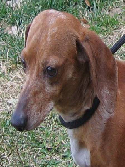

In [193]:
index = random.choice(range(x_valid_set.shape[0]))
print(index)
predict_image(x_valid_set,preds,index)

In [176]:
def accuracy(predicted,expected,threshold):
    train_output = pd.DataFrame([predicted,expected],index=['predicted','expected']).T
    true_pos = train_output[(train_output.predicted > threshold) & (train_output.expected == 1)]
    true_neg = train_output[(train_output.predicted < threshold) & (train_output.expected == 0)]
    correct = len(true_pos) + len(true_neg)
    accuracy = (correct/len(train_output))*100
    
    return accuracy

In [137]:
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}".format(0.1*i,accuracy(preds,y_valid_set,0.1*i)))

For threshold of 0.100000, accuracy is 55.800000000000004
For threshold of 0.200000, accuracy is 57.3
For threshold of 0.300000, accuracy is 57.3
For threshold of 0.400000, accuracy is 57.8
For threshold of 0.500000, accuracy is 58.8
For threshold of 0.600000, accuracy is 60.5
For threshold of 0.700000, accuracy is 59.0
For threshold of 0.800000, accuracy is 58.199999999999996
For threshold of 0.900000, accuracy is 56.599999999999994


### Model Loss

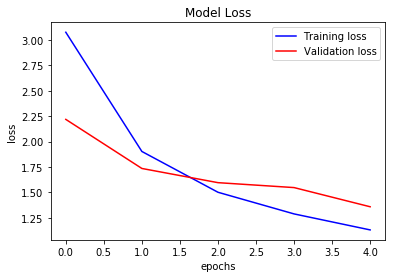

In [157]:
plt.plot([0,1,2,3,4], [3.0753,1.9028,1.5017,1.2888,1.1314], color='b', label="Training loss")
plt.plot([0,1,2,3,4], [2.2184,1.7357,1.5961,1.5477,1.3591], color='r', label="Validation loss")

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend()

plt.savefig("1CNN_loss.png",bbox_inches='tight',dpi=300)
plt.show()

### Model MSE

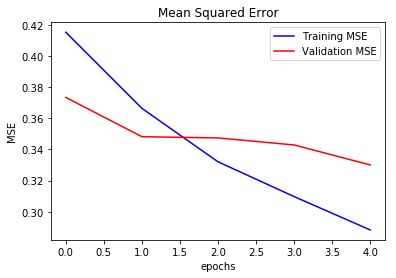

In [153]:
plt.plot([0,1,2,3,4], [0.4152,0.3664,0.3321,0.3098,0.2884], color='b', label="Training MSE")
plt.plot([0,1,2,3,4], [0.3734,0.3482,0.3474,0.3429,0.3301], color='r', label="Validation MSE")

plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()

plt.savefig("1CNN_MSE.png",bbox_inches='tight',dpi=300)
plt.show()

## 2-layer CNN
Input --> Convolutional Layer --> Convolutional Layer --> Fully Connected Layer --> Output

In [89]:
fc_layer_size = 256

conv_inputs = keras.Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3), name='ani_image')
conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_x = layers.Flatten(name = 'flattened_features')(conv_layer) #turn image to vector.

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

In [90]:
customAdam = keras.optimizers.Adam(lr=1e-6)
conv_model.compile(optimizer=customAdam,
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [91]:
print('# Fit model on training data')

history = conv_model.fit(x_train_set, 
                    y_train_set,
                    batch_size=64, 
                    shuffle = True,
                    epochs=5,
                    validation_data=(x_valid_set, y_valid_set))

# Fit model on training data
Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 612s 122ms/step - loss: 2.0702 - binary_crossentropy: 2.0702 - mean_squared_error: 0.4036 - val_loss: 1.6526 - val_binary_crossentropy: 1.6526 - val_mean_squared_error: 0.3780
Epoch 2/5
5000/5000 [==============================] - 466s 93ms/step - loss: 1.4775 - binary_crossentropy: 1.4775 - mean_squared_error: 0.3510 - val_loss: 1.3174 - val_binary_crossentropy: 1.3174 - val_mean_squared_error: 0.3362
Epoch 3/5
5000/5000 [==============================] - 482s 96ms/step - loss: 1.2669 - binary_crossentropy: 1.2669 - mean_squared_error: 0.3240 - val_loss: 1.2181 - val_binary_crossentropy: 1.2181 - val_mean_squared_error: 0.3221
Epoch 4/5
5000/5000 [==============================] - 495s 99ms/step - loss: 1.1639 - binary_crossentropy: 1.1639 - mean_squared_error: 0.3084 - val_loss: 1.2091 - val_binary_crossentropy: 1.2091 - val_mean_squared_error: 0.3235
Ep

In [92]:
preds_2CNN = conv_model.predict(x_valid_set).flatten()
np.corrcoef(preds_2CNN, y_valid_set)

array([[1.        , 0.20392255],
       [0.20392255, 1.        ]])

Probability that the image is a cat: 0.08724834


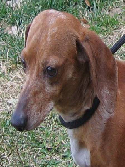

In [194]:
# index = random.choice(range(x_valid_set.shape[0]))
predict_image(x_valid_set,preds_2CNN,index)

In [138]:
#accuracy of the prediction
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}".format(0.1*i,accuracy(preds_2CNN,y_valid_set,0.1*i)))

For threshold of 0.100000, accuracy is 59.3
For threshold of 0.200000, accuracy is 59.5
For threshold of 0.300000, accuracy is 59.3
For threshold of 0.400000, accuracy is 58.4
For threshold of 0.500000, accuracy is 57.8
For threshold of 0.600000, accuracy is 57.49999999999999
For threshold of 0.700000, accuracy is 57.49999999999999
For threshold of 0.800000, accuracy is 56.99999999999999
For threshold of 0.900000, accuracy is 55.50000000000001


### Visualize loss function

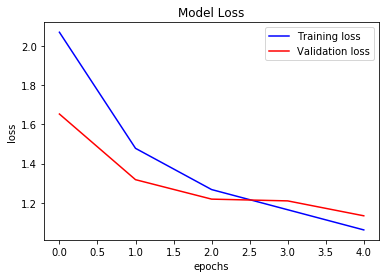

In [156]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend()

plt.savefig("2CNN_loss.png",bbox_inches='tight',dpi=300)
plt.show()

### Visualize MSE

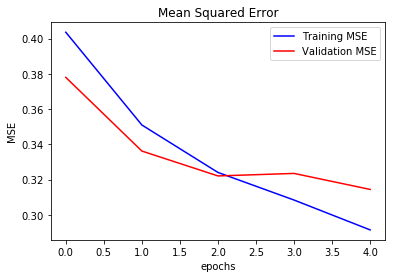

In [155]:
plt.plot(history.history['mean_squared_error'], color='b', label="Training MSE")
plt.plot(history.history['val_mean_squared_error'], color='r', label="Validation MSE")

plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()

plt.savefig("2CNN_MSE.png",bbox_inches='tight',dpi=300)
plt.show()

## References
[1] Convolutional Neural Networks: A Python Tutorial Using TensorFlow and Keras, https://www.kdnuggets.com/2019/07/convolutional-neural-networks-python-tutorial-tensorflow-keras.html

[2] Source code from [1], https://github.com/StrikingLoo/Cats-and-dogs-classifier-tensorflow-CNN/blob/master/Convolutional_experiments.ipynb

[3] Keras CNN Dog or Cat Classification, https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification#See-sample-image

[4] Convolutional Neural Networks (CNNs / ConvNets), https://cs231n.github.io/convolutional-networks/